In [1]:
import pandas as pd
import numpy as np
from numpy import concatenate
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib
from sklearn.model_selection import train_test_split
import itertools
import re
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
df_unemployment=pd.read_csv('Japan Dataset\DP_LIVE_18042023124659745.csv')
df_unemployment.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,AUS,HUR,TOT,PC_LF,A,1967,1.875,NaN
1,AUS,HUR,TOT,PC_LF,A,1968,1.850,NaN
2,AUS,HUR,TOT,PC_LF,A,1969,1.800,NaN
3,AUS,HUR,TOT,PC_LF,A,1970,1.625,NaN
4,AUS,HUR,TOT,PC_LF,A,1971,1.925,NaN


In [3]:
df_unemployment_japan=df_unemployment[(df_unemployment['LOCATION']=='JPN')&(df_unemployment['SUBJECT']=='TOT')].copy()
df_unemployment_japan_men=df_unemployment[(df_unemployment['LOCATION']=='JPN')&(df_unemployment['SUBJECT']=='MEN')].copy()
df_unemployment_japan_women=df_unemployment[(df_unemployment['LOCATION']=='JPN')&
                                            (df_unemployment['SUBJECT']=='WOMEN')].copy()

In [4]:
df_unemployment_japan_monthly=df_unemployment_japan[df_unemployment_japan['TIME'].str.contains(r'\d{4}\-\d{2}',regex=True)]
df_unemployment_japan_men_monthly=df_unemployment_japan_men[df_unemployment_japan_men['TIME'].str.contains(r'\d{4}\-\d{2}',regex=True)]
df_unemployment_japan_women_monthly=df_unemployment_japan_women[df_unemployment_japan_women['TIME'].str.contains(r'\d{4}\-\d{2}',regex=True)]

In [5]:
[val for val in df_unemployment_japan_men_monthly['TIME'].to_list() if val not in df_unemployment_japan_monthly['TIME'].to_list()]

['1953-01',
 '1953-02',
 '1953-03',
 '1953-04',
 '1953-05',
 '1953-06',
 '1953-07',
 '1953-08',
 '1953-09',
 '1953-10',
 '1953-11',
 '1953-12',
 '1954-01',
 '1954-02',
 '1954-03',
 '1954-04',
 '1954-05',
 '1954-06',
 '1954-07',
 '1954-08',
 '1954-09',
 '1954-10',
 '1954-11',
 '1954-12']

In [6]:
df_unemployment_japan_monthly2=df_unemployment_japan_monthly.copy()
df_unemployment_japan_monthly2['TIME']=pd.to_datetime(df_unemployment_japan_monthly2['TIME'],format='%Y-%m')
df_unemployment_japan_monthly2=df_unemployment_japan_monthly2.set_index('TIME')

In [7]:
df_unemployment_japan_monthly2.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,Value,Flag Codes
TIME,,,,,,,
1955-01-01,JPN,HUR,TOT,PC_LF,M,2.6,NaN
1955-02-01,JPN,HUR,TOT,PC_LF,M,2.5,NaN
1955-03-01,JPN,HUR,TOT,PC_LF,M,2.3,NaN
1955-04-01,JPN,HUR,TOT,PC_LF,M,2.5,NaN
1955-05-01,JPN,HUR,TOT,PC_LF,M,2.4,NaN


# 1. Baseline Model : Univariate Time Series ARIMA

https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

## 1.1. EDA

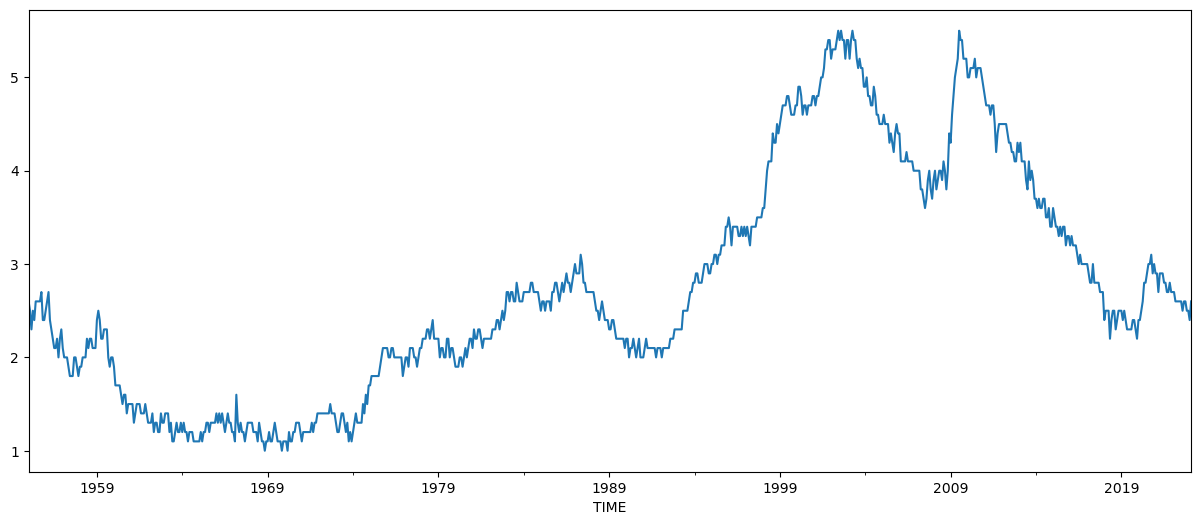

In [8]:
df_unemployment_japan_monthly2['Value'].plot(figsize=(15, 6))
plt.show()

### 1.1.1. Decomposing Time Series to Trend, Seasonality and Residuals

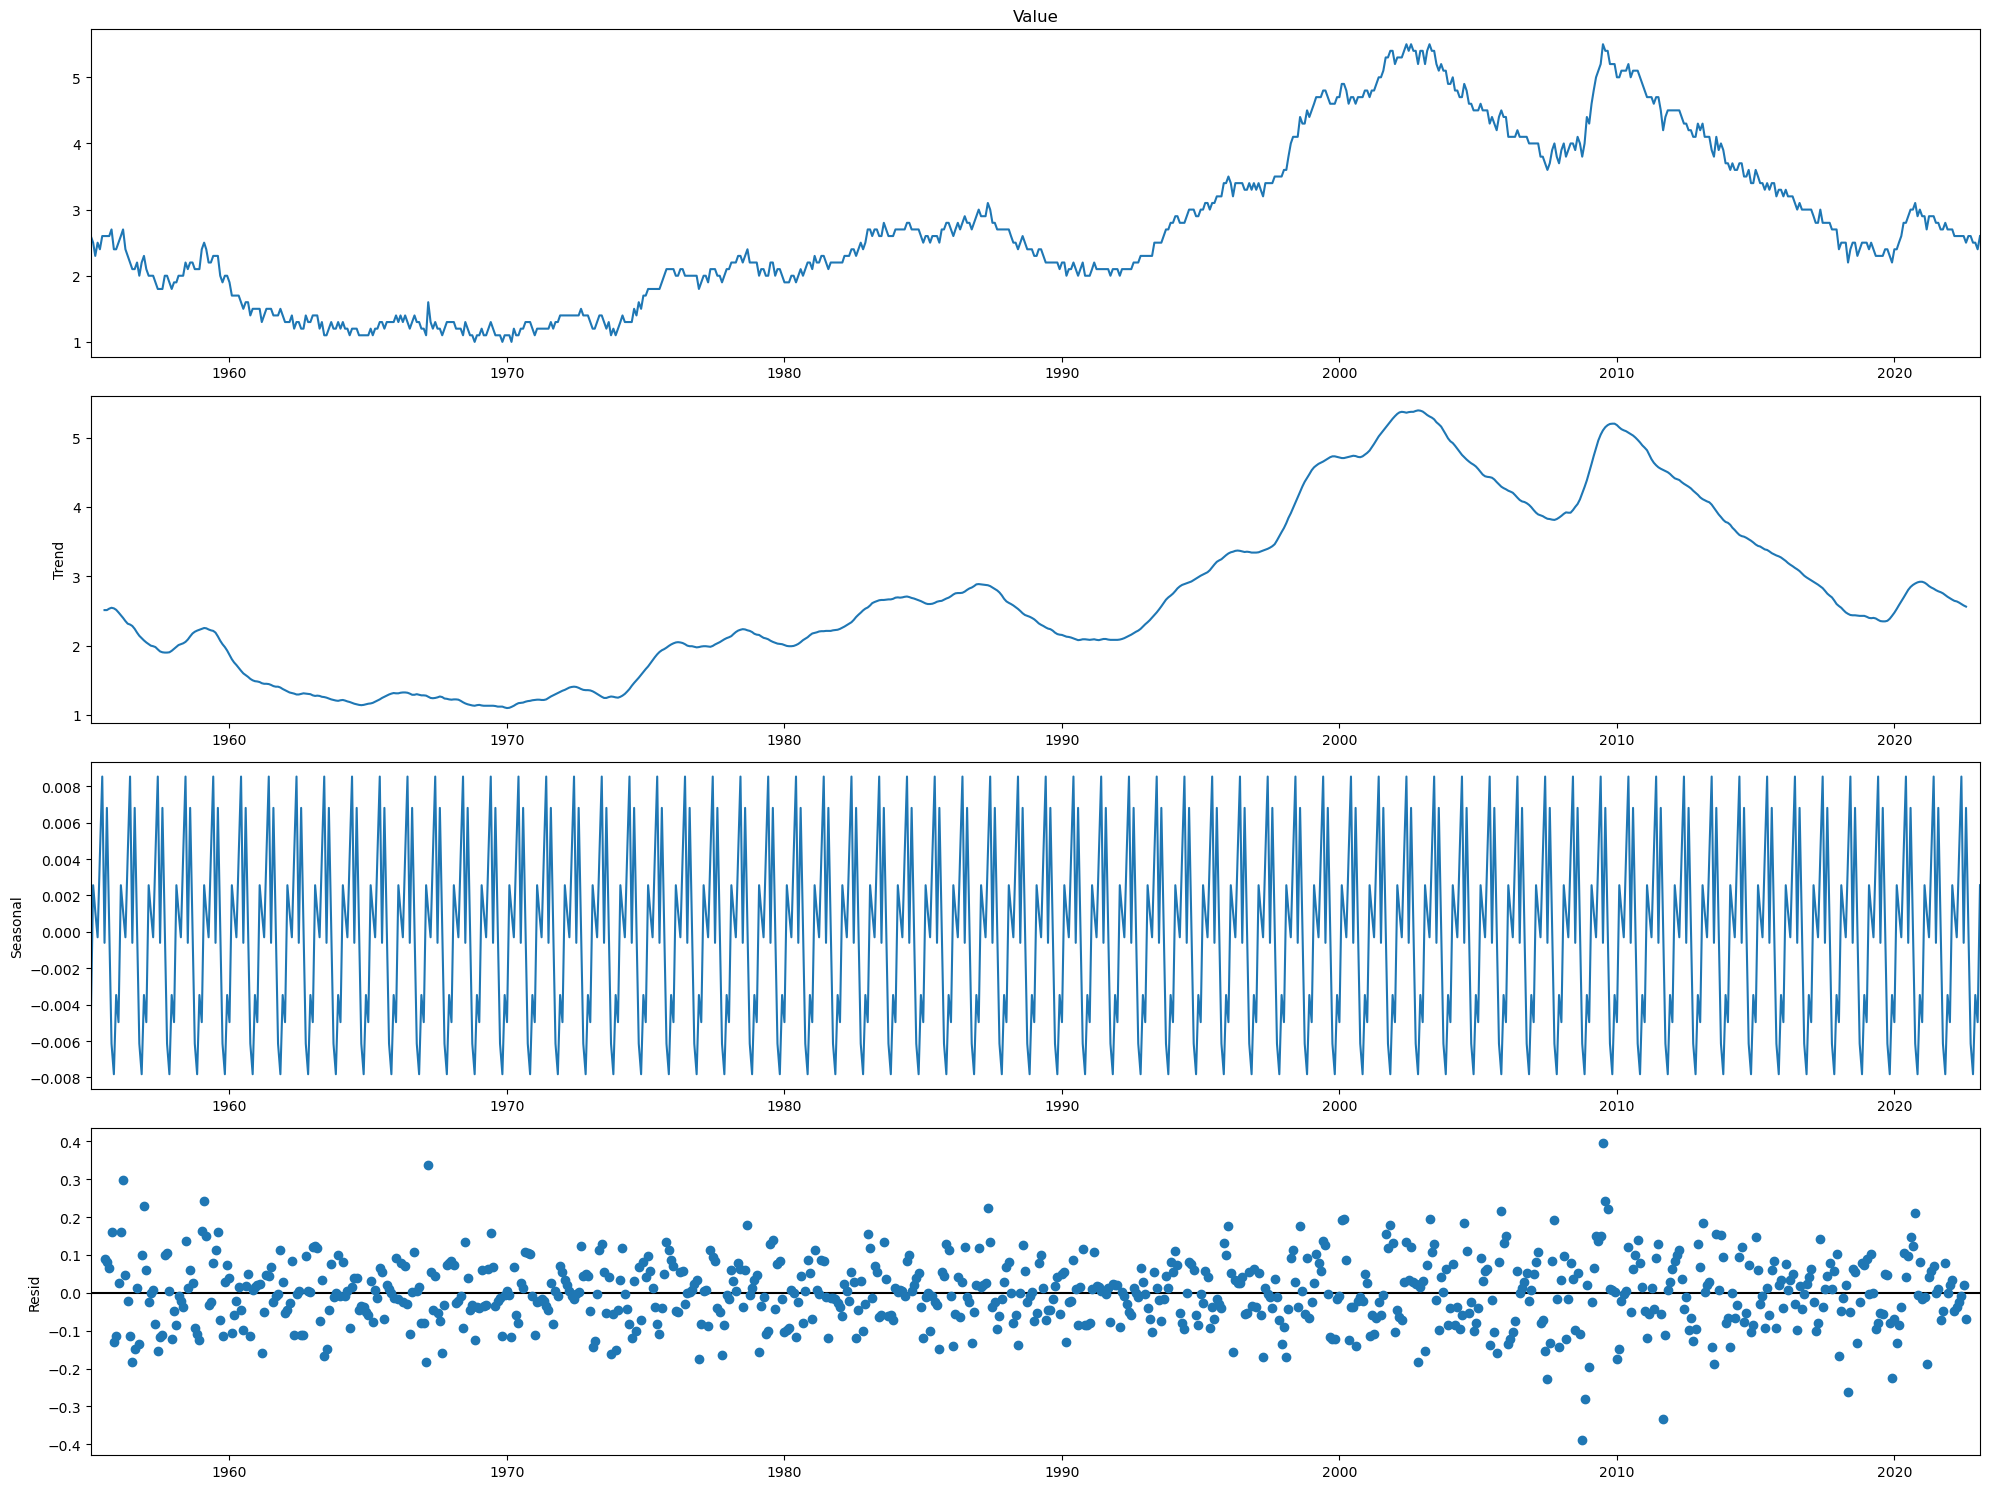

In [9]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 15
decomposition = sm.tsa.seasonal_decompose(df_unemployment_japan_monthly2['Value'], model='additive')
fig = decomposition.plot()
plt.show()

### 1.1.2. Checking Stationarity and De-Trending

In [10]:
adfuller_result = adfuller(df_unemployment_japan_monthly2['Value'].values, autolag='AIC')
print('ADF statistics: ', adfuller_result[0])
print('p-value: ', adfuller_result[1])
if adfuller_result[1] >= 0.05:
    print('Non-stationary time series, convert to stationary time series')
else:
    print('Stationary time series, ARIMA can be implemented')

ADF statistics:  -1.3619917354566102
p-value:  0.6003561164037803
Non-stationary time series, convert to stationary time series


## 1.2. Modelling 

In [11]:
X_train=df_unemployment_japan_monthly2.iloc[0:806,0:5]
Y_train=df_unemployment_japan_monthly2.iloc[0:806,5]

X_test=df_unemployment_japan_monthly2.iloc[806:,0:5]
Y_test=df_unemployment_japan_monthly2.iloc[806:,5]

### 1.2.1. Determining optimum p,d,q values

In [12]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [13]:
warnings.filterwarnings("ignore")
aic_value=99999
for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(Y_train,
                                        order=param,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

        results = mod.fit()
        if results.aic<aic_value:
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            aic_value=results.aic

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:4055.944307352036
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2997.5554585514947
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:542.9067094455331
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:483.4203154758968
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:479.4010837212858
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:-63.21157560178284
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:-74.84612762970681
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-1333.5940355390007
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:-1364.0412626129842
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:-1382.127144127302
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:-1393.661597084133


### 1.2.2. Fitting Model

In [14]:
mod = sm.tsa.statespace.SARIMAX(Y_train,
                                order=(0, 1, 1),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1417      0.033     -4.358      0.000      -0.205      -0.078
ar.S.L12       0.3932      0.076      5.142      0.000       0.243       0.543
ma.S.L12      -0.6732      0.062    -10.772      0.000      -0.796      -0.551
sigma2         0.0099      0.000     23.278      0.000       0.009       0.011


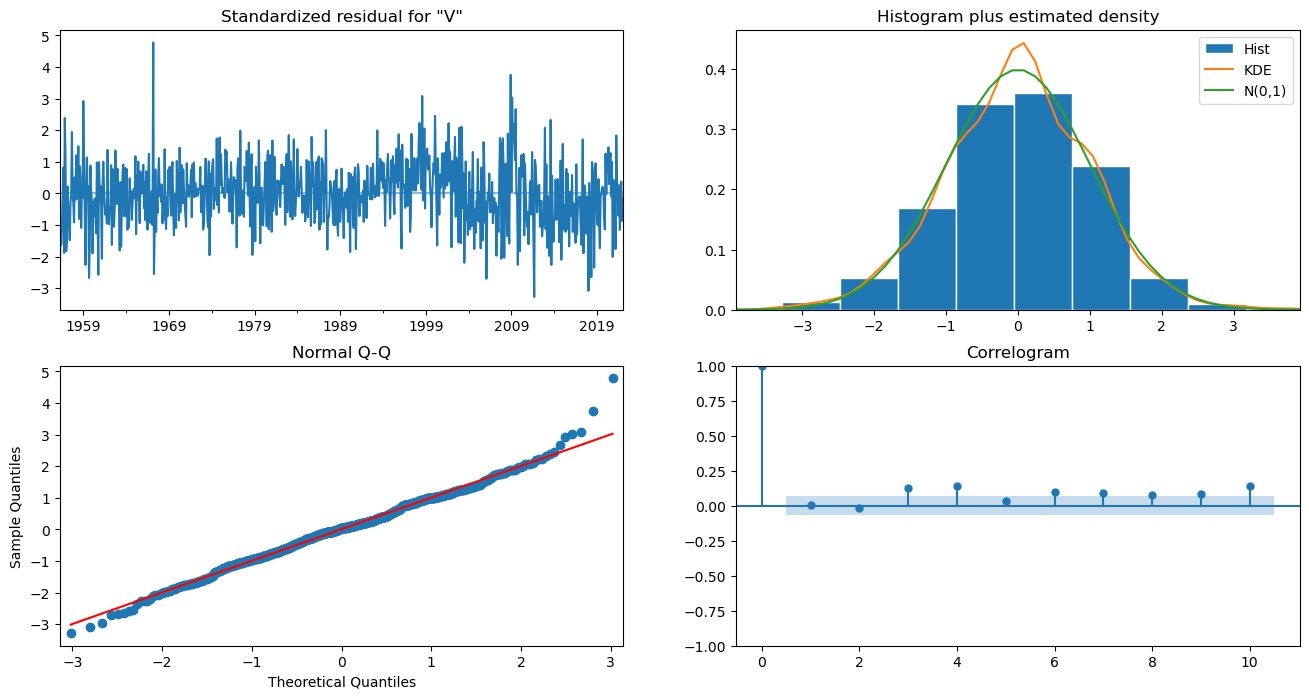

In [15]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

### 1.2.3. Model Results

In [16]:
predictions={}
for date in Y_test.index:
    pred=results.get_prediction(pd.to_datetime(date))
    predictions[date]=pred.predicted_mean[0]

In [17]:
y_forecasted = np.array(list(predictions.values()))
y_truth = Y_test.values
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Root Mean Squared Error of our forecasts is {}'.format(sqrt(round(mse, 2))))

The Root Mean Squared Error of our forecasts is 0.1414213562373095


# 2. Multivariate Time Series Forecasting with LSTMs

Strategy : To predict for Apr 23, need to have all features till Mar 23. Reframe features to 1 step back
    
Train data till Mar 22 , test accuracy on next 1 year and predict for Apr 23

## 2.1. DATA prep and EDA

### 2.1.1. Production and Labour IMF data

In [18]:
df_production_labour=pd.read_excel(r'E:\Jupyter notebooks\hackathon23_somnolence\data\raw\third_party\imf\prices_production_and_labour\Prices_Production_and_Labor_Japan.xlsx',sheet_name='Monthly_Data')
df_production_labour['Indicator'].unique()

array(['Prices', 'Financial Market Prices, Equities, Index',
       'Prices, Producer Price Index, All Commodities, Index',
       'Prices, Consumer Price Index, All items, Index', 'Production',
       'Economic Activity, Industrial Production, Manufacturing, Index',
       'Economic Activity, Industrial Production, Index',
       'Industrial Production, Seasonally adjusted, Index', 'Labor',
       'Labor Markets, Wage Rates, Index',
       'Labor Force, Persons, Number of',
       'Employment, Persons, Number of',
       'Unemployment, Persons, Number of',
       'Labor Markets, Unemployment Rate, Percent'], dtype=object)

In [19]:
time_col=[col for col in df_production_labour.columns if re.search(r'\d{4}',str(col),re.I)!=None]

df_production_labour_restructured=pd.melt(df_production_labour,id_vars='Indicator',value_vars=time_col,var_name='timeframe')
df_production_labour_restructured=pd.pivot(df_production_labour_restructured,index='timeframe',columns='Indicator',values='value').reset_index()

df_production_labour_restructured['timeframe_year']=df_production_labour_restructured['timeframe'].str.split('M',expand=True)[0]
df_production_labour_restructured['timeframe_month']=df_production_labour_restructured['timeframe'].str.split('M',expand=True)[1]

df_production_labour_restructured['TIME']=df_production_labour_restructured['timeframe_year']+'-'+df_production_labour_restructured['timeframe_month']

df_production_labour_restructured.drop(columns=['timeframe','timeframe_month','timeframe_year','Prices'],inplace=True)

In [20]:
df_MRD=pd.merge(df_unemployment_japan_monthly,df_production_labour_restructured,on='TIME',how='inner')
df_MRD['TIME']=pd.to_datetime(df_MRD['TIME'],format='%Y-%m')
df_MRD=df_MRD.set_index('TIME')

feature_col=['Economic Activity, Industrial Production, Index',
             'Economic Activity, Industrial Production, Manufacturing, Index',
             'Financial Market Prices, Equities, Index',
             'Industrial Production, Seasonally adjusted, Index',
             'Labor Markets, Wage Rates, Index',
             'Prices, Consumer Price Index, All items, Index',
             'Prices, Producer Price Index, All Commodities, Index']

target_col=['Value']

df_MRD=df_MRD[feature_col+target_col]
for col in df_MRD.columns:
    df_MRD[col]=pd.to_numeric(df_MRD[col],errors='coerce')
    
df_MRD.head()

,"Economic Activity, Industrial Production, Index","Economic Activity, Industrial Production, Manufacturing, Index","Financial Market Prices, Equities, Index","Industrial Production, Seasonally adjusted, Index","Labor Markets, Wage Rates, Index","Prices, Consumer Price Index, All items, Index","Prices, Producer Price Index, All Commodities, Index",Value
TIME,,,,,,,,
1990-01-01,90.630605,92.593293,311.508388,98.176707,86.385602,92.937029,107.607981,2.2
1990-02-01,96.407061,99.373580,302.643796,98.670057,87.185469,93.040637,107.607981,2.2
1990-03-01,109.354291,113.146037,255.843582,100.446118,87.585402,93.351464,107.705629,2.0
1990-04-01,100.988389,104.564737,244.278173,100.643458,89.085152,94.180333,107.705629,2.1
1990-05-01,97.701784,101.068651,267.136876,101.334148,88.885186,94.594768,107.607981,2.1


### 2.1.2. OECD Consumer and Business Confidence Data

### 2.1.3. OPEC Import Data

### 2.1.4. GDP and Interest Rate IMF Data

### 2.1.5. Scaling and Adjusting Seasonality and Trend Analysis

In [21]:
scaler=MinMaxScaler()
df_MRD_scaled=scaler.fit_transform(df_MRD)
df_MRD_scaled=pd.DataFrame(df_MRD_scaled,columns=df_MRD.columns)

df_MRD_scaled.index=df_MRD.index
df_MRD_scaled.head()

,"Economic Activity, Industrial Production, Index","Economic Activity, Industrial Production, Manufacturing, Index","Financial Market Prices, Equities, Index","Industrial Production, Seasonally adjusted, Index","Labor Markets, Wage Rates, Index","Prices, Consumer Price Index, All items, Index","Prices, Producer Price Index, All Commodities, Index",Value
TIME,,,,,,,,
1990-01-01,0.380511,0.409522,1.000000,0.549048,0.000000,0.000000,0.858974,0.057143
1990-02-01,0.487775,0.531892,0.961302,0.561362,0.042781,0.005925,0.858974,0.057143
1990-03-01,0.728193,0.780457,0.756997,0.605689,0.064171,0.023700,0.865385,0.000000
1990-04-01,0.572846,0.625582,0.706508,0.610614,0.144385,0.071100,0.865385,0.028571
1990-05-01,0.511817,0.562485,0.806297,0.627852,0.133690,0.094801,0.858974,0.028571


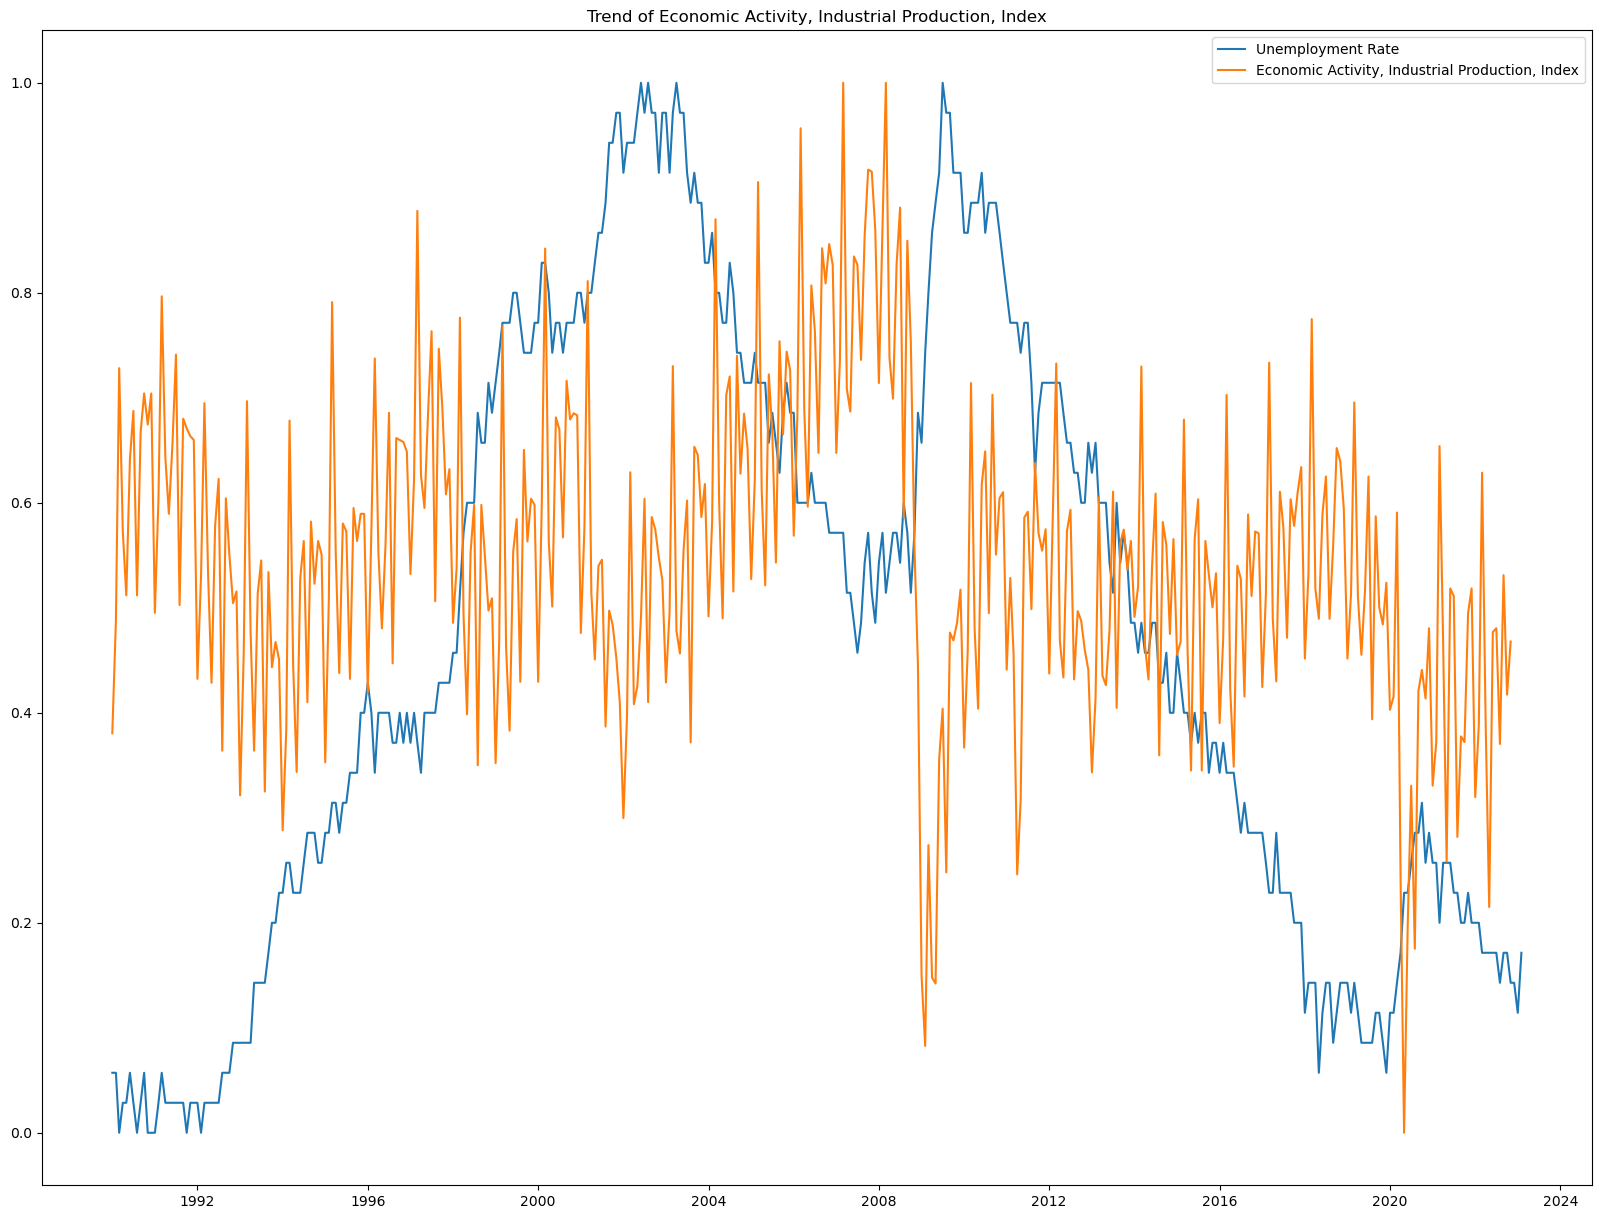

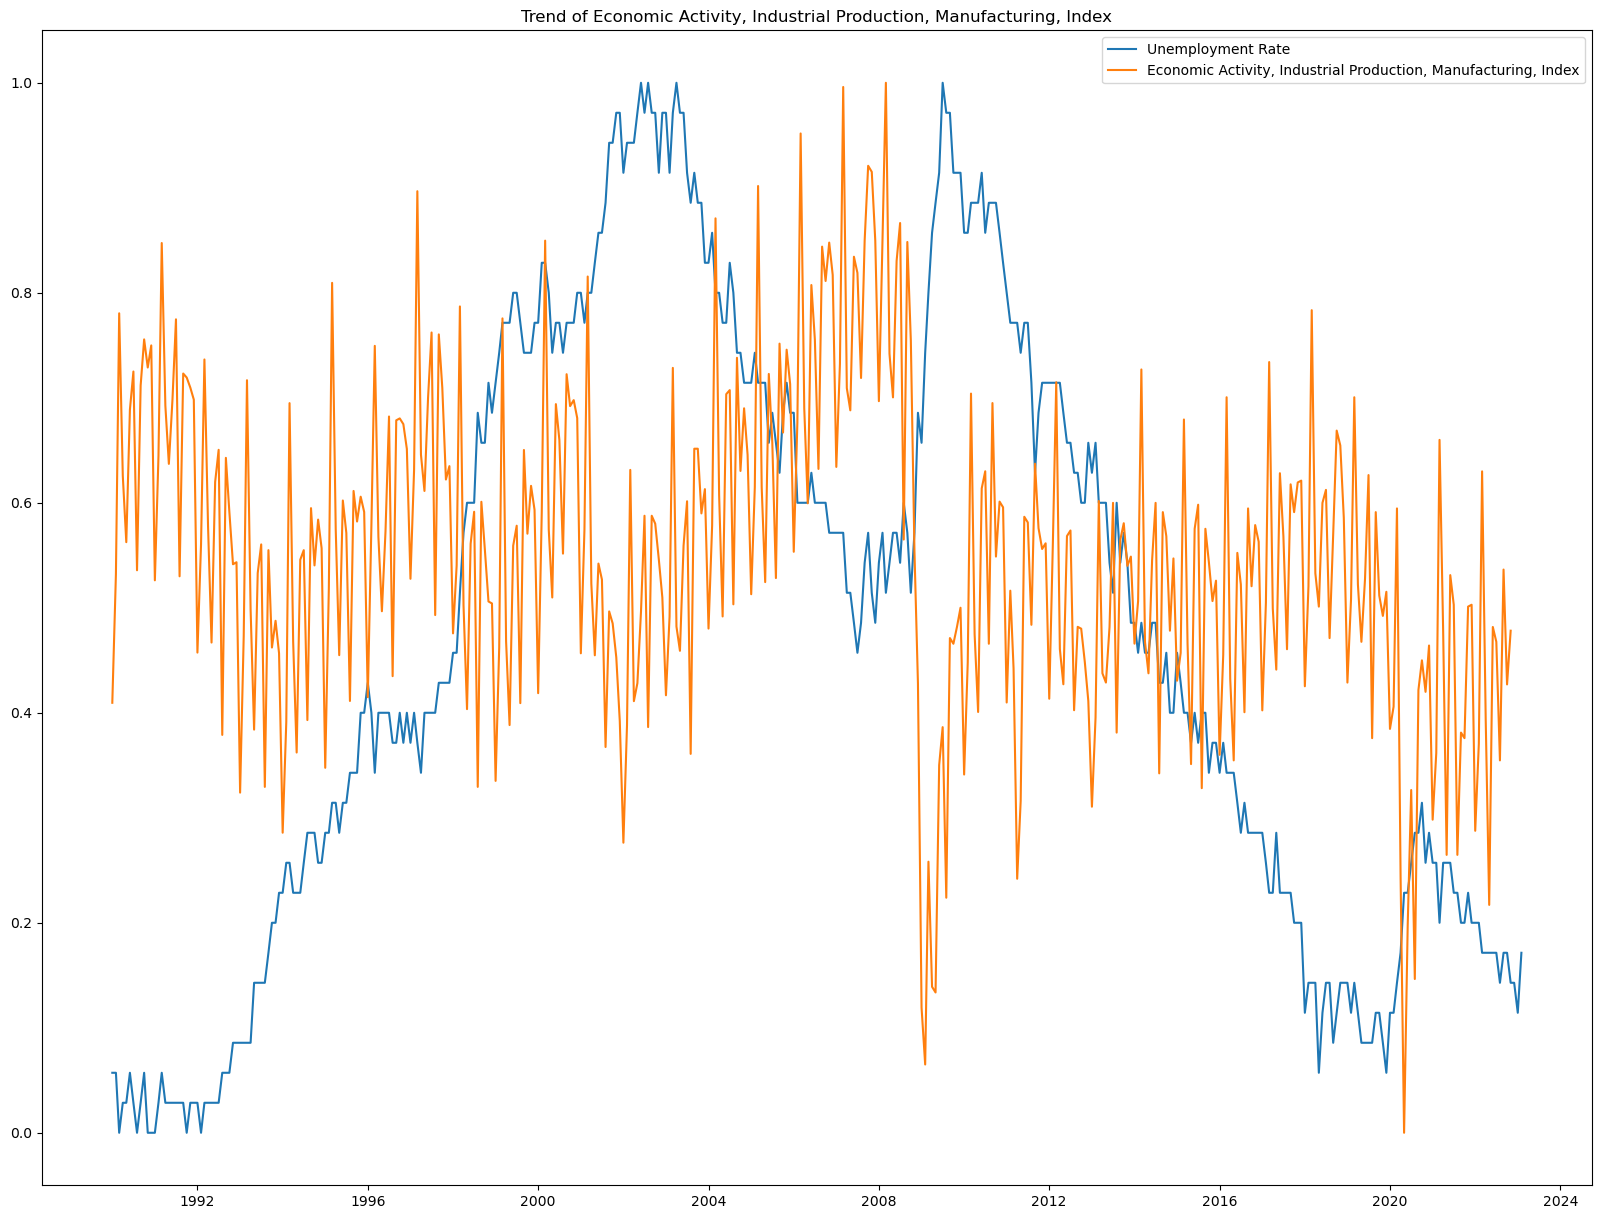

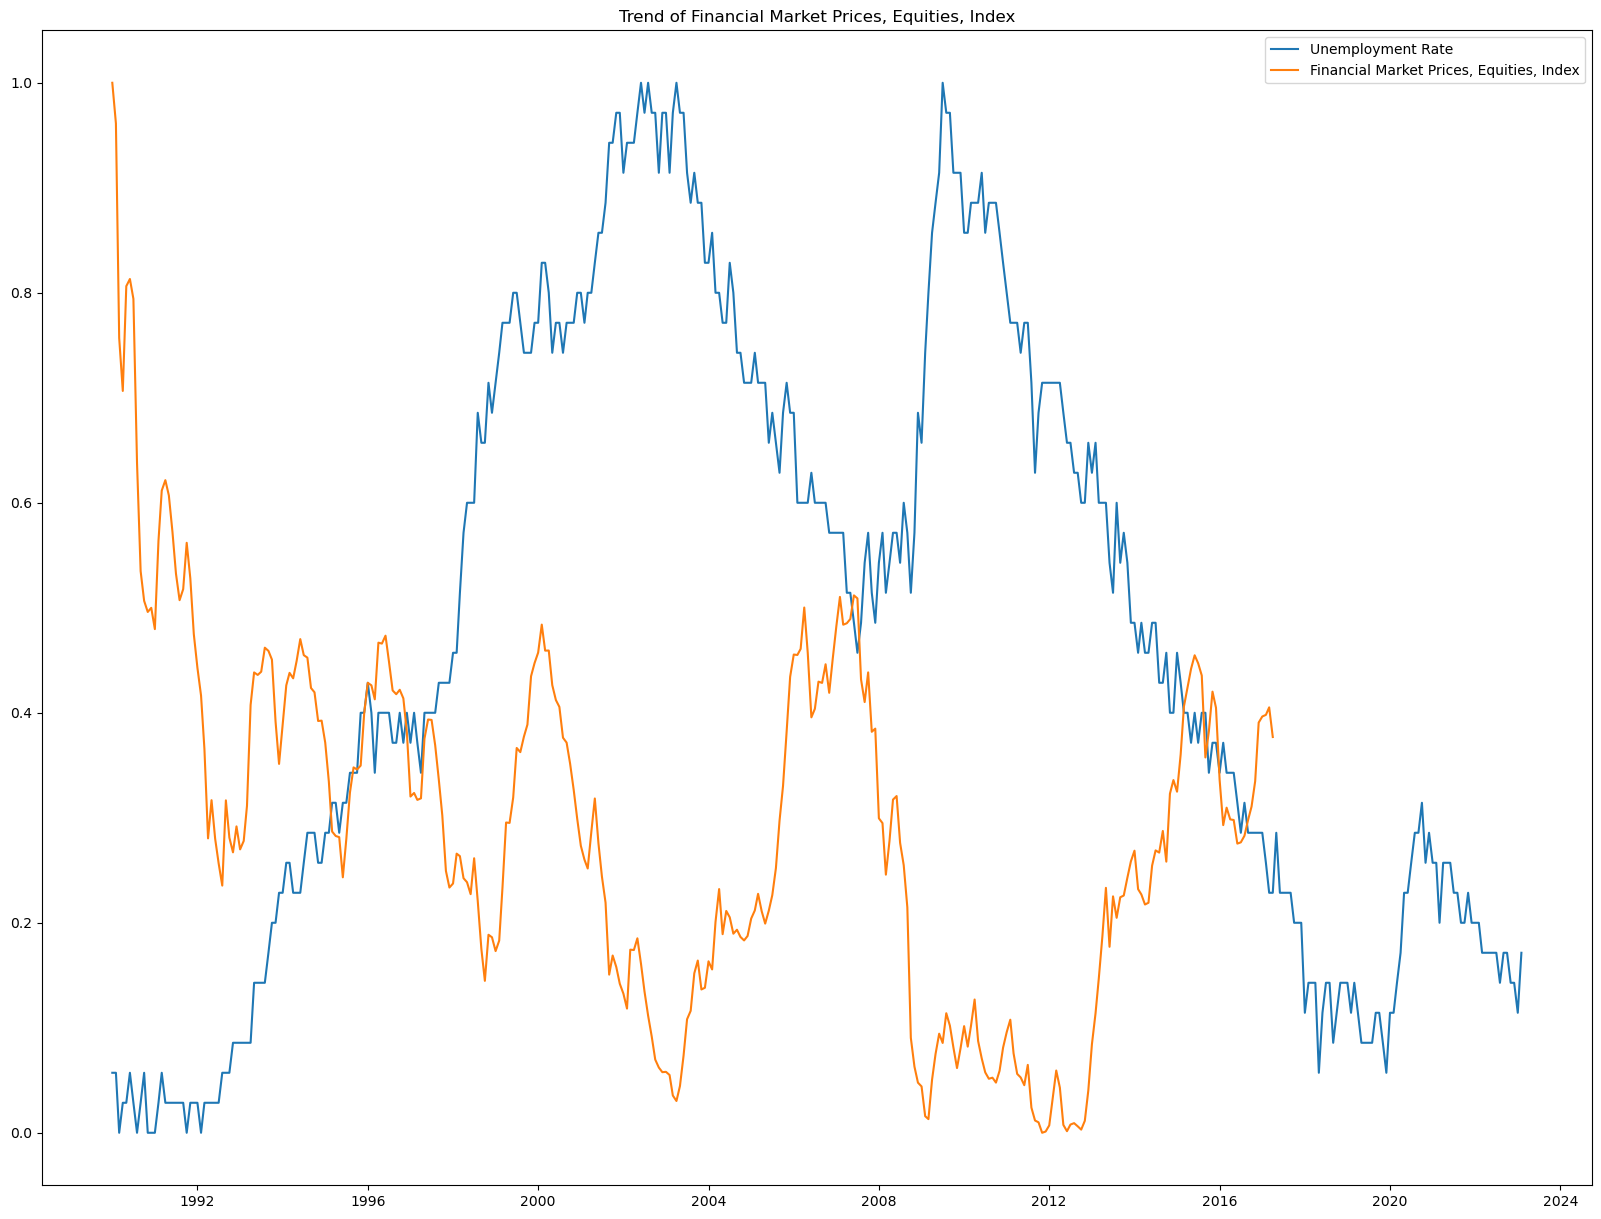

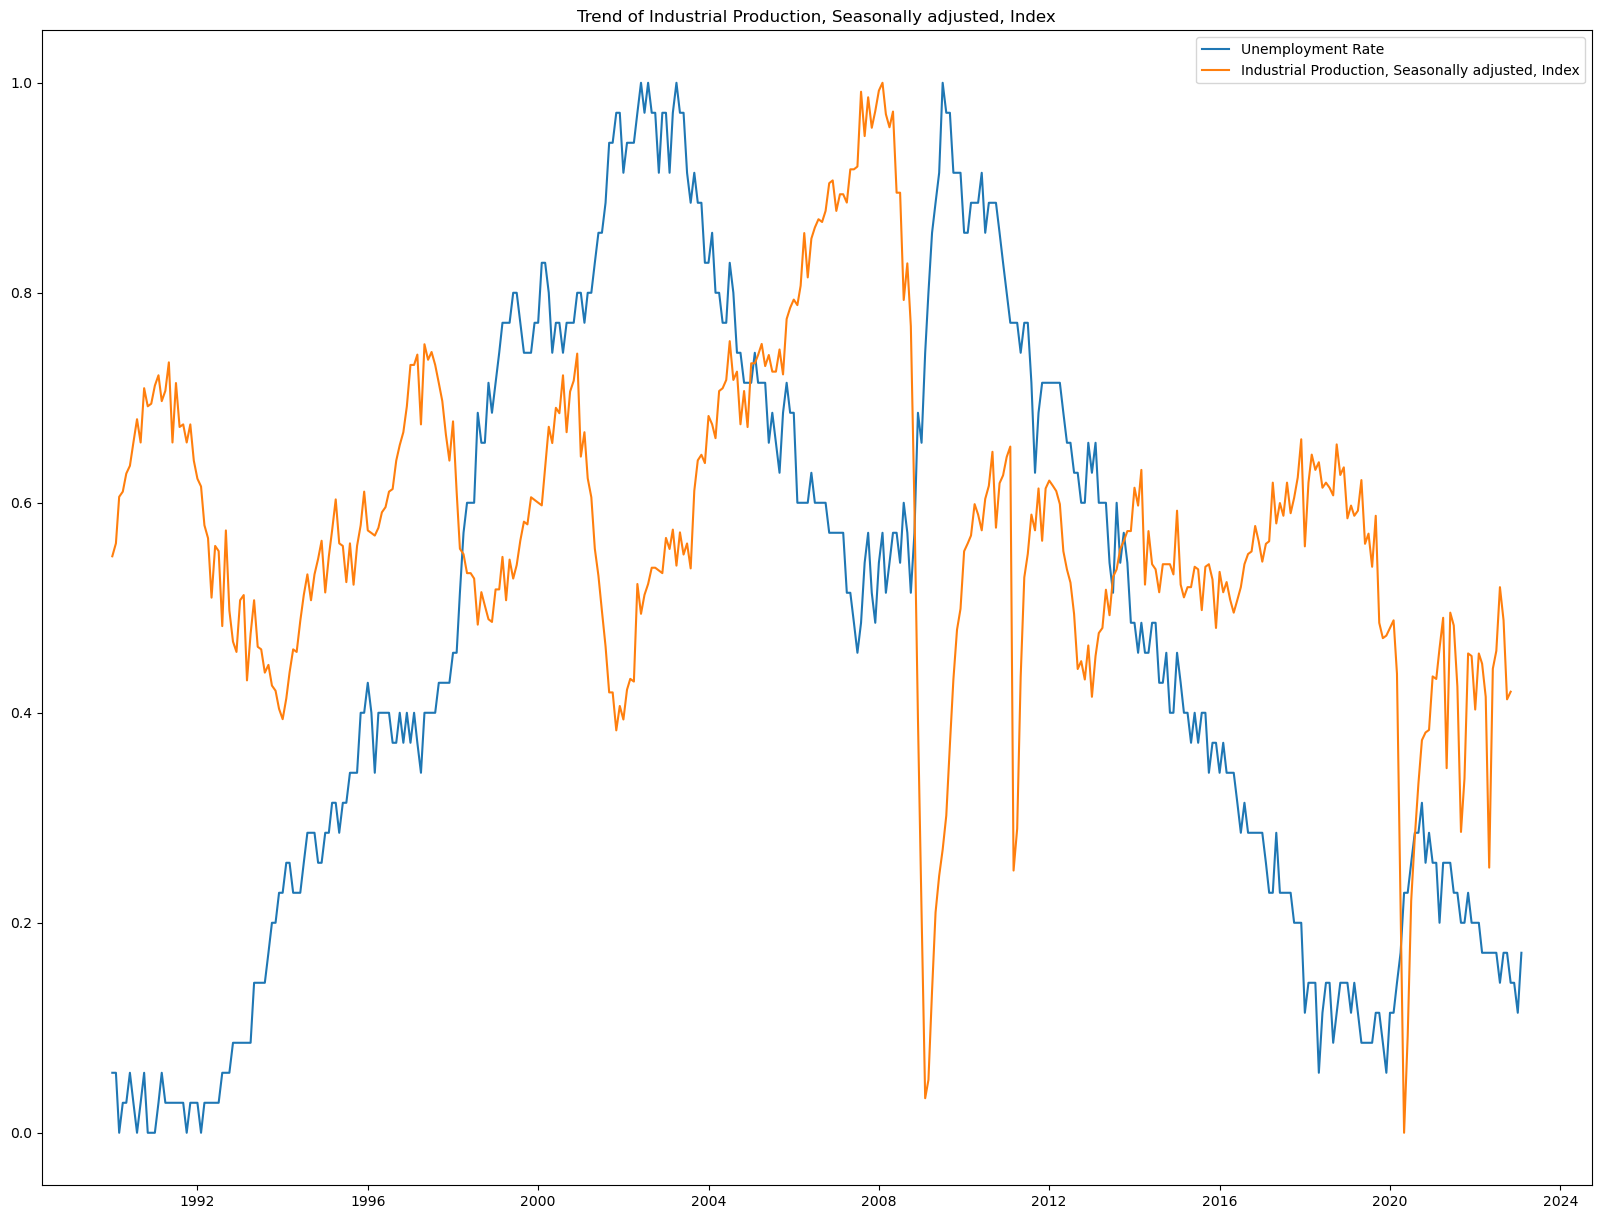

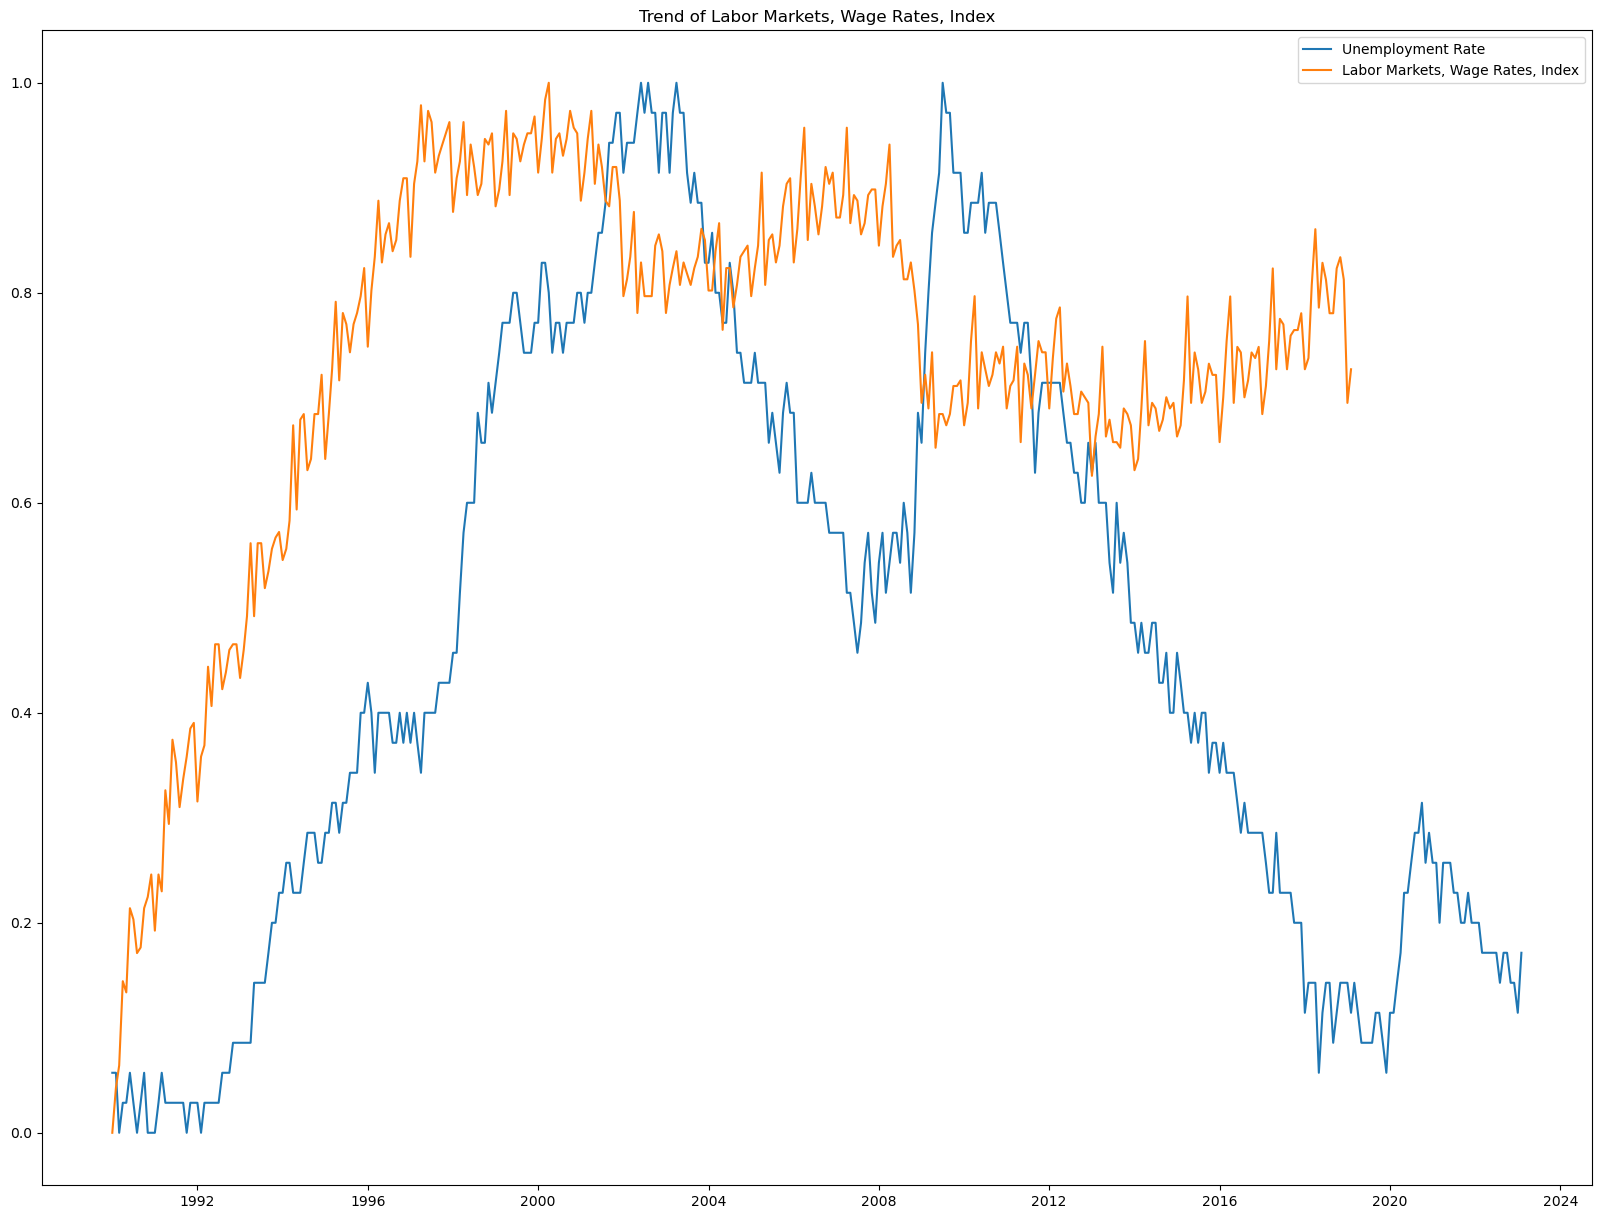

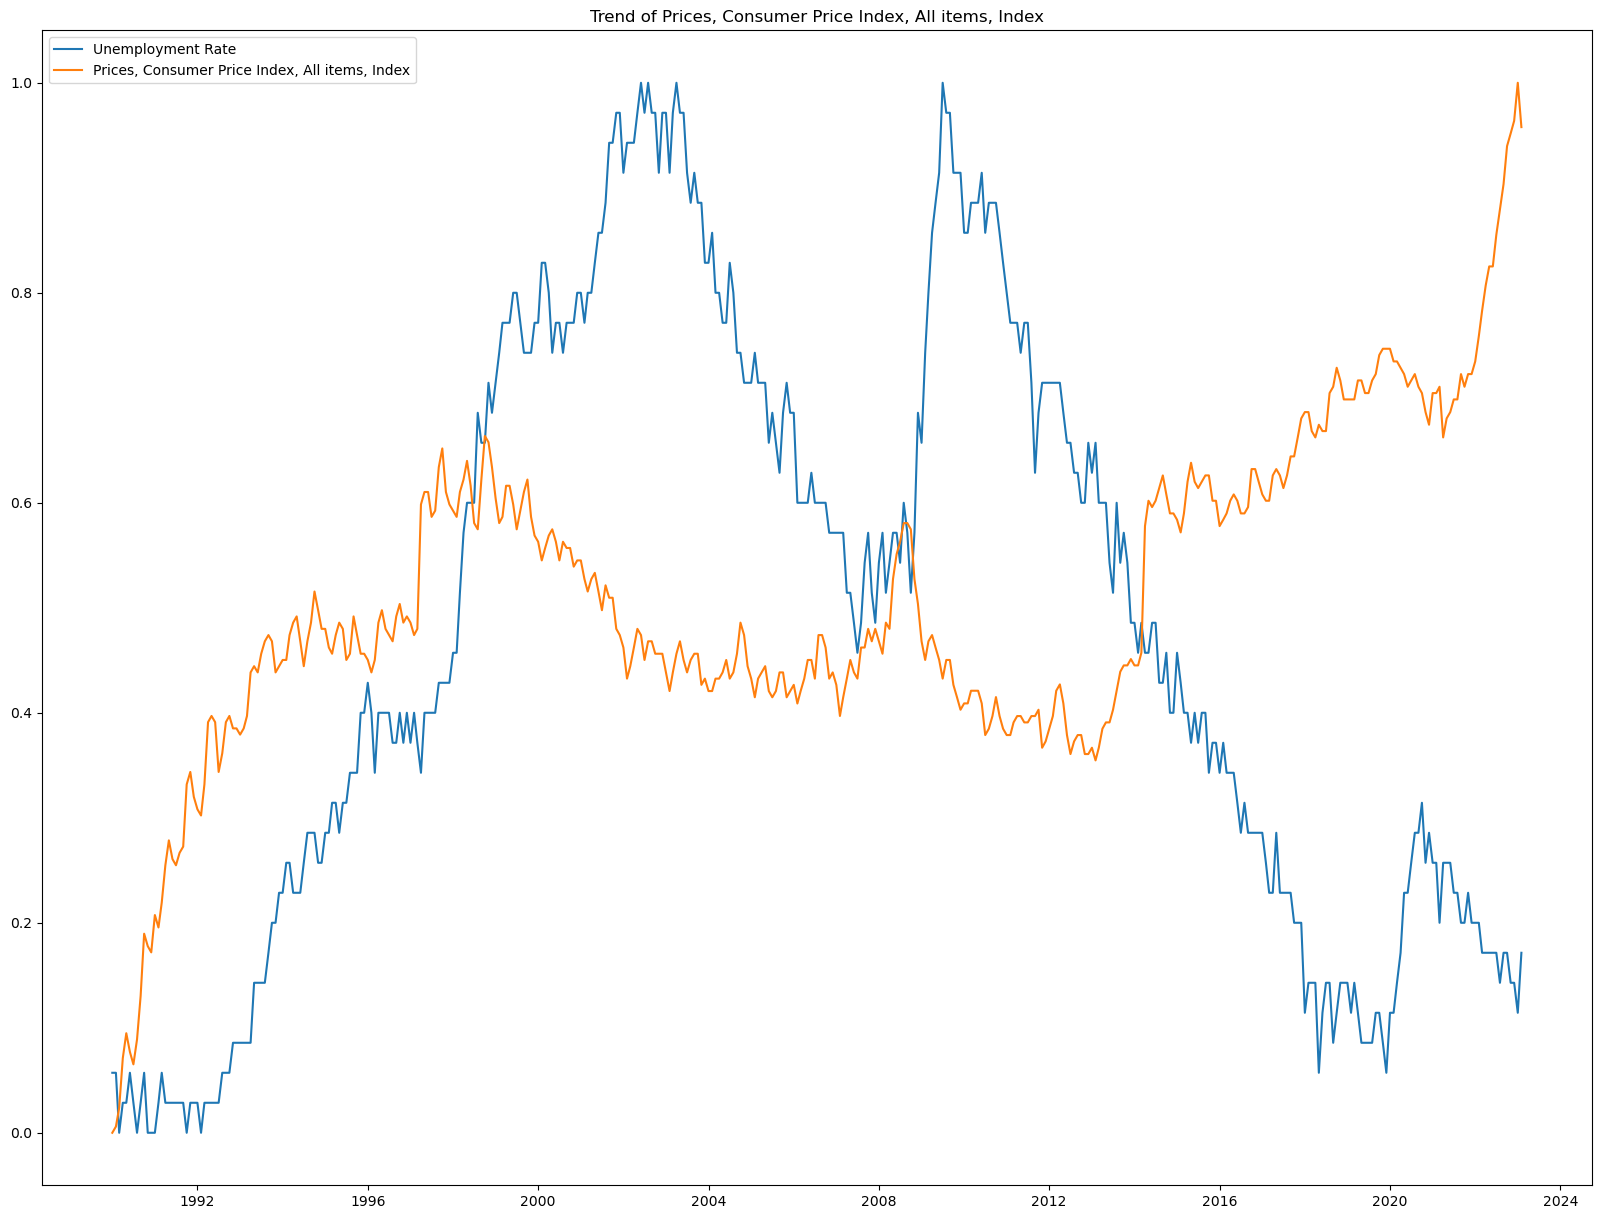

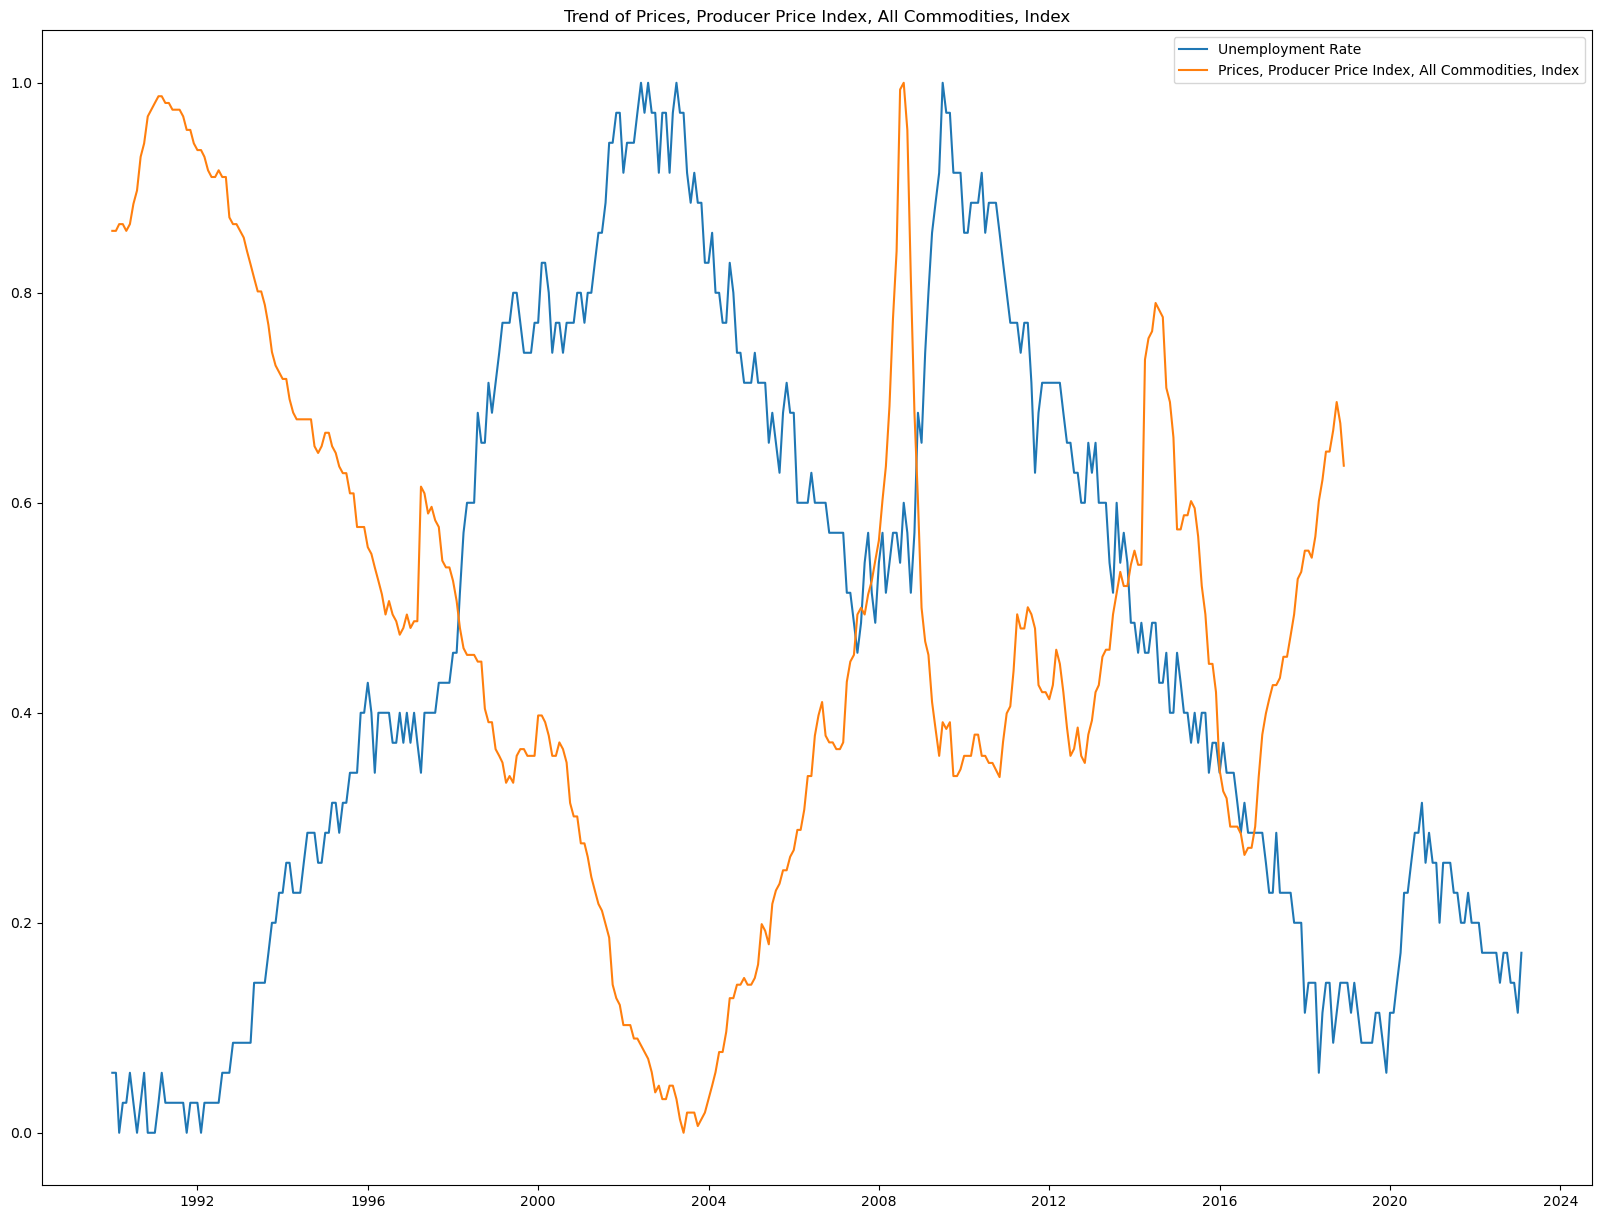

In [22]:
for col in feature_col:
    plt.plot(figsize=(15,6))
    plt.plot(df_MRD_scaled['Value'],label='Unemployment Rate')
    plt.plot(df_MRD_scaled[col],label=col)
    plt.title('Trend of %s'%(col))
    plt.legend()
    plt.show()

## 2.2. Modelling

### 2.2.1. Reframe time series to supervised learning

In [23]:
df_MRD_scaled

,"Economic Activity, Industrial Production, Index","Economic Activity, Industrial Production, Manufacturing, Index","Financial Market Prices, Equities, Index","Industrial Production, Seasonally adjusted, Index","Labor Markets, Wage Rates, Index","Prices, Consumer Price Index, All items, Index","Prices, Producer Price Index, All Commodities, Index",Value
TIME,,,,,,,,
1990-01-01,0.380511,0.409522,1.000000,0.549048,0.000000,0.000000,0.858974,0.057143
1990-02-01,0.487775,0.531892,0.961302,0.561362,0.042781,0.005925,0.858974,0.057143
1990-03-01,0.728193,0.780457,0.756997,0.605689,0.064171,0.023700,0.865385,0.000000
1990-04-01,0.572846,0.625582,0.706508,0.610614,0.144385,0.071100,0.865385,0.028571
1990-05-01,0.511817,0.562485,0.806297,0.627852,0.133690,0.094801,0.858974,0.028571
...,...,...,...,...,...,...,...,...
2022-10-01,0.417280,0.427002,NaN,0.412790,NaN,0.939687,NaN,0.171429
2022-11-01,0.467859,0.478172,NaN,0.420074,NaN,0.951750,NaN,0.142857
2022-12-01,NaN,NaN,NaN,NaN,NaN,0.963812,NaN,0.142857


In [24]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [25]:
reframed_dataset = series_to_supervised(df_MRD_scaled, 4, 4)

### 2.2.2. Feature Selection

In [26]:
reframed_dataset_final=reframed_dataset[['var4(t-1)','var5(t-1)','var6(t-1)','var7(t-1)',
                                         'var8(t-1)','var8(t-2)','var8(t-3)','var8(t-4)']]

reframed_dataset_final=pd.merge(reframed_dataset_final, df_MRD[['Value']], left_index=True, right_index=True, how='left')
reframed_dataset_final

,var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var8(t-2),var8(t-3),var8(t-4),Value
TIME,,,,,,,,,
1990-05-01,0.610614,0.144385,0.071100,0.865385,0.028571,0.000000,0.057143,0.057143,2.1
1990-06-01,0.627852,0.133690,0.094801,0.858974,0.028571,0.028571,0.000000,0.057143,2.2
1990-07-01,0.635240,0.213904,0.077025,0.865385,0.057143,0.028571,0.028571,0.000000,2.1
1990-08-01,0.657404,0.203209,0.065175,0.884615,0.028571,0.057143,0.028571,0.028571,2.0
1990-09-01,0.679567,0.171123,0.088876,0.897436,0.000000,0.028571,0.057143,0.028571,2.1
...,...,...,...,...,...,...,...,...,...
2016-09-01,0.541483,0.700459,0.589872,0.264624,0.314286,0.285714,0.314286,0.342857,3.0
2016-10-01,0.551196,0.716470,0.595904,0.271363,0.285714,0.314286,0.285714,0.314286,3.0
2016-11-01,0.553624,0.743153,0.632091,0.271363,0.285714,0.285714,0.314286,0.285714,3.0


### 2.2.3. Split to train-test and reframe

In [27]:
reframed_dataset_final=reframed_dataset_final.values

train_limit=reframed_dataset_final.shape[0]-12

train_X=reframed_dataset_final[0:train_limit,:-1]
train_Y=reframed_dataset_final[0:train_limit,-1]

test_X=reframed_dataset_final[train_limit:,:-1]
test_Y=reframed_dataset_final[train_limit:,-1]

In [28]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)

(309, 1, 8) (309,) (12, 1, 8) (12,)


### 2.2.4. Fitting Model

Epoch 1/50
5/5 - 3s - loss: 3.9625 - val_loss: 3.0693 - 3s/epoch - 521ms/step
Epoch 2/50
5/5 - 0s - loss: 3.8907 - val_loss: 3.0095 - 57ms/epoch - 11ms/step
Epoch 3/50
5/5 - 0s - loss: 3.8180 - val_loss: 2.9486 - 44ms/epoch - 9ms/step
Epoch 4/50
5/5 - 0s - loss: 3.7437 - val_loss: 2.8859 - 47ms/epoch - 9ms/step
Epoch 5/50
5/5 - 0s - loss: 3.6663 - val_loss: 2.8202 - 47ms/epoch - 9ms/step
Epoch 6/50
5/5 - 0s - loss: 3.5846 - val_loss: 2.7506 - 47ms/epoch - 9ms/step
Epoch 7/50
5/5 - 0s - loss: 3.4972 - val_loss: 2.6759 - 47ms/epoch - 9ms/step
Epoch 8/50
5/5 - 0s - loss: 3.4030 - val_loss: 2.5954 - 47ms/epoch - 9ms/step
Epoch 9/50
5/5 - 0s - loss: 3.3009 - val_loss: 2.5081 - 50ms/epoch - 10ms/step
Epoch 10/50
5/5 - 0s - loss: 3.1896 - val_loss: 2.4132 - 46ms/epoch - 9ms/step
Epoch 11/50
5/5 - 0s - loss: 3.0683 - val_loss: 2.3100 - 47ms/epoch - 9ms/step
Epoch 12/50
5/5 - 0s - loss: 2.9361 - val_loss: 2.1976 - 47ms/epoch - 9ms/step
Epoch 13/50
5/5 - 0s - loss: 2.7923 - val_loss: 2.0755 - 44

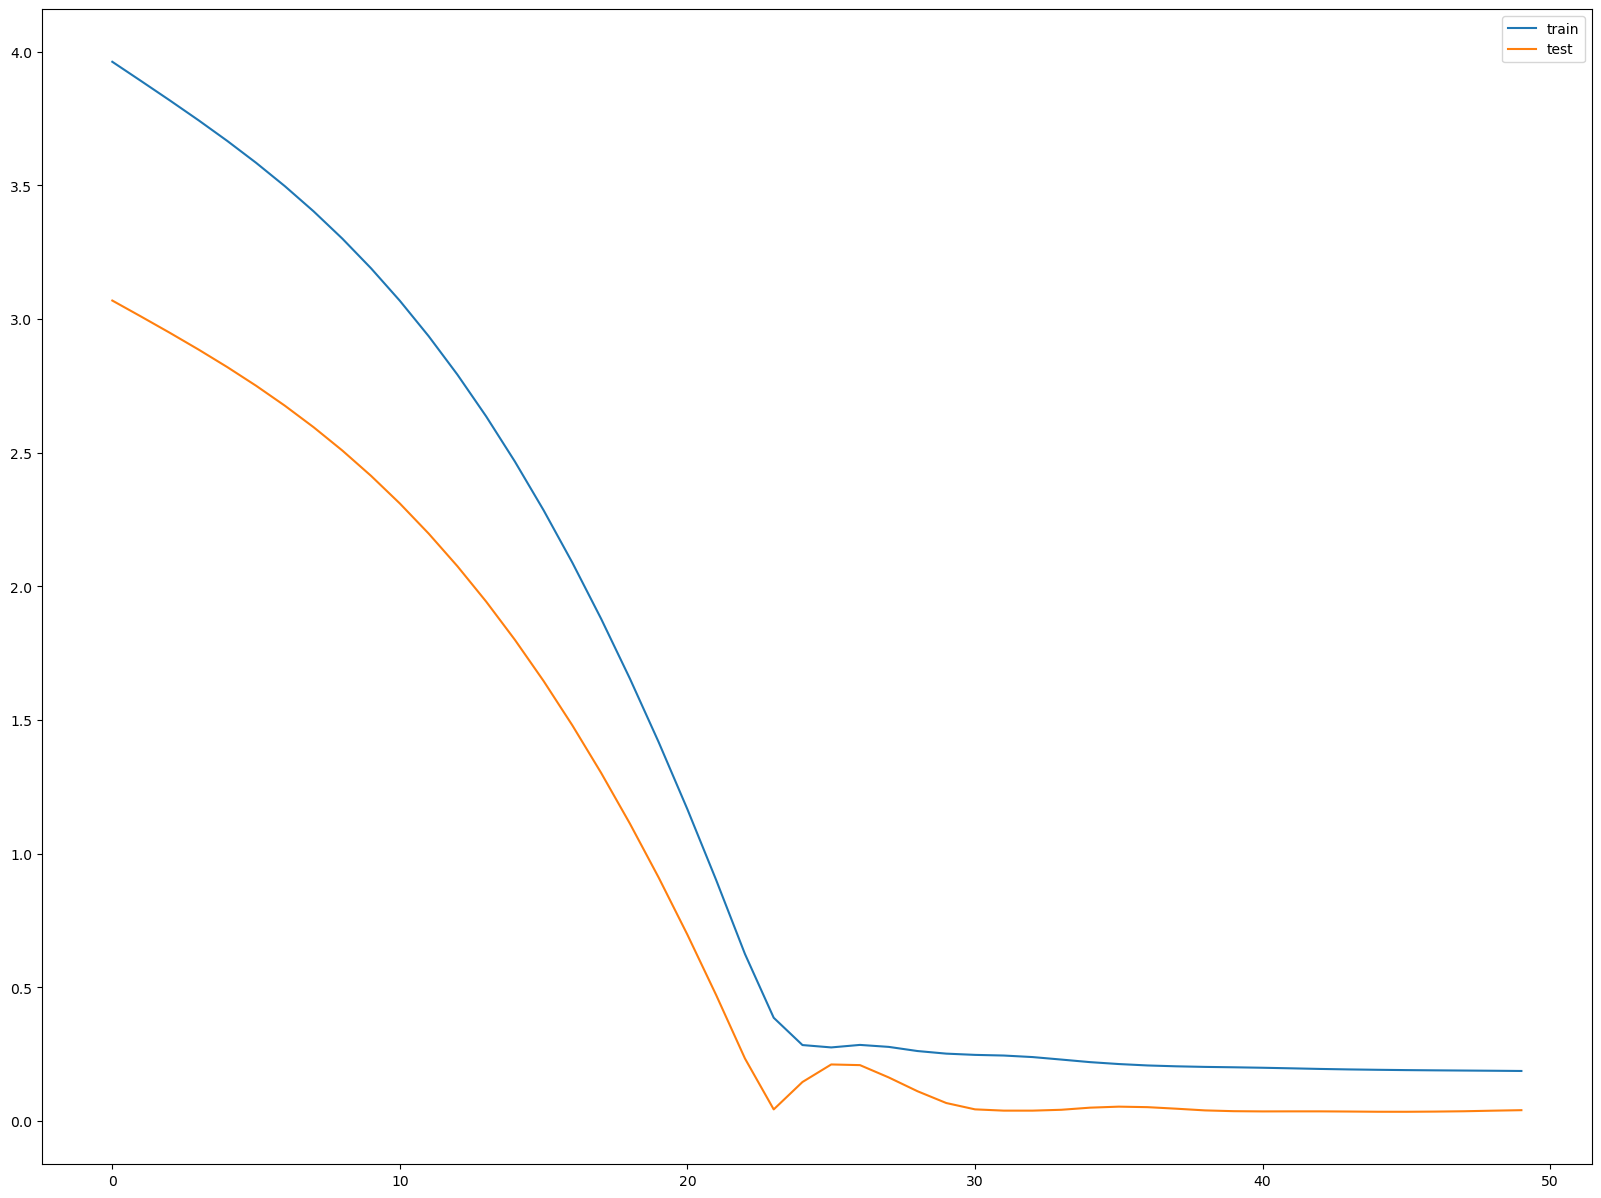

In [29]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_Y, epochs=50, batch_size=72, validation_data=(test_X, test_Y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### 2.2.5. Prediction and RMSE

In [30]:
yhat = model.predict(test_X)
rmse = sqrt(mean_squared_error(test_Y, yhat))
print('Test RMSE: %.3f' % rmse)

1/1 [==============================] - 0s 453ms/step
Test RMSE: 0.061
